In [1]:
import pandas as pd
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays

from neuralprophet import NeuralProphet
from prophet import Prophet
from prophet.serialize import model_to_json
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

import sys
import os

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
from get_metrics import get_metrics

# Количество предсказанных дней
pred_days_forecast = 180

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [2]:
# Чтение DataFrame df в файл data/df.csv
df = pd.read_csv('../data/df.csv')

# Чтение DataFrame df_train в файл data/df_train.csv
df_train = pd.read_csv('../data/df_train.csv')

# Чтение DataFrame df_test в файл data/df_test.csv
df_test = pd.read_csv('../data/df_test.csv')

In [3]:
# Преобразование столбца ds в формат datetime
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d', dayfirst=True)
df_train['ds'] = pd.to_datetime(df_train['ds'], format='%Y-%m-%d', dayfirst=True)
df_test['ds'] = pd.to_datetime(df_test['ds'], format='%Y-%m-%d', dayfirst=True)

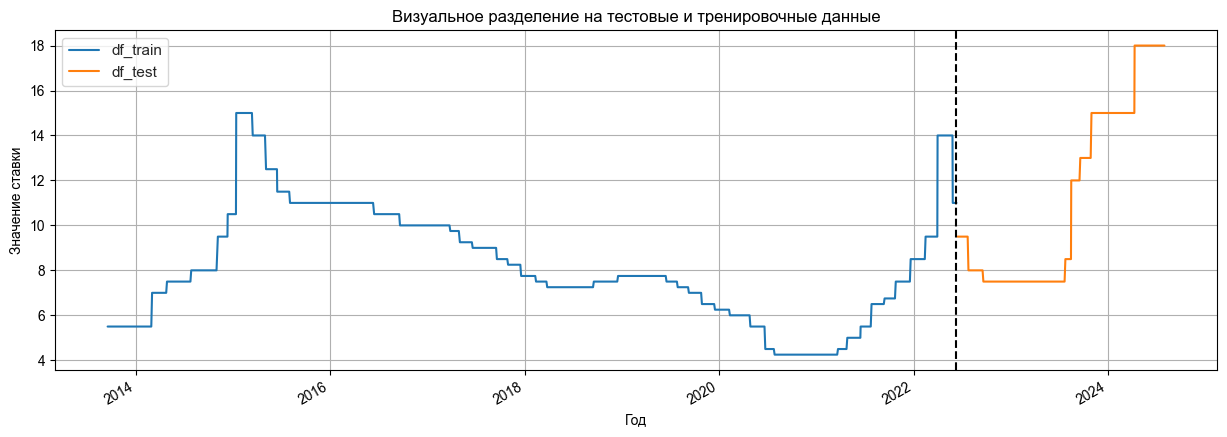

In [4]:
# Отображаем график с разделением train, test для наглядности
fig, ax = plt.subplots(figsize = (10, 5))

sns.set_theme(style="whitegrid", palette="Accent")

fig.set_figheight(5)
fig.set_figwidth(15)
df_train.set_index('ds').plot(ax=ax, label= 'train', title='Визуальное разделение на тестовые и тренировочные данные')
df_test.set_index('ds').plot(ax=ax, label='test')
ax.axvline(df_train['ds'][-1:].values, ls='--', color='black')
ax.legend(['df_train', 'df_test'])
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

# Baseline Prophet on df_train для проверки модели

In [5]:
# Обучение модели на train
model_baseline = Prophet()
model_baseline.fit(df_train)

00:33:47 - cmdstanpy - INFO - Chain [1] start processing
00:33:49 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
# Период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*0.2)

In [7]:
# Создание df с прогнозом
future = model_baseline.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_baseline.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2705,2023-11-30,16.809693,12.315808,21.708564
2706,2023-12-01,16.811120,12.258855,21.729972
2707,2023-12-02,16.933071,12.270245,21.837090
2708,2023-12-03,16.945480,12.408066,22.007772
2709,2023-12-04,16.831303,12.214823,21.693579


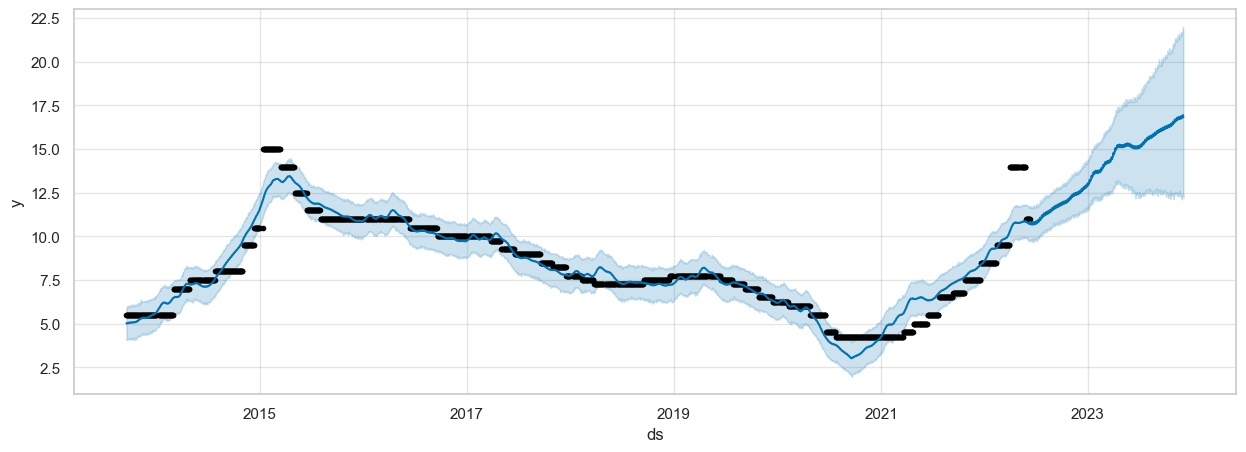

In [8]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_baseline.plot(forecast,ax=ax)
plt.show()

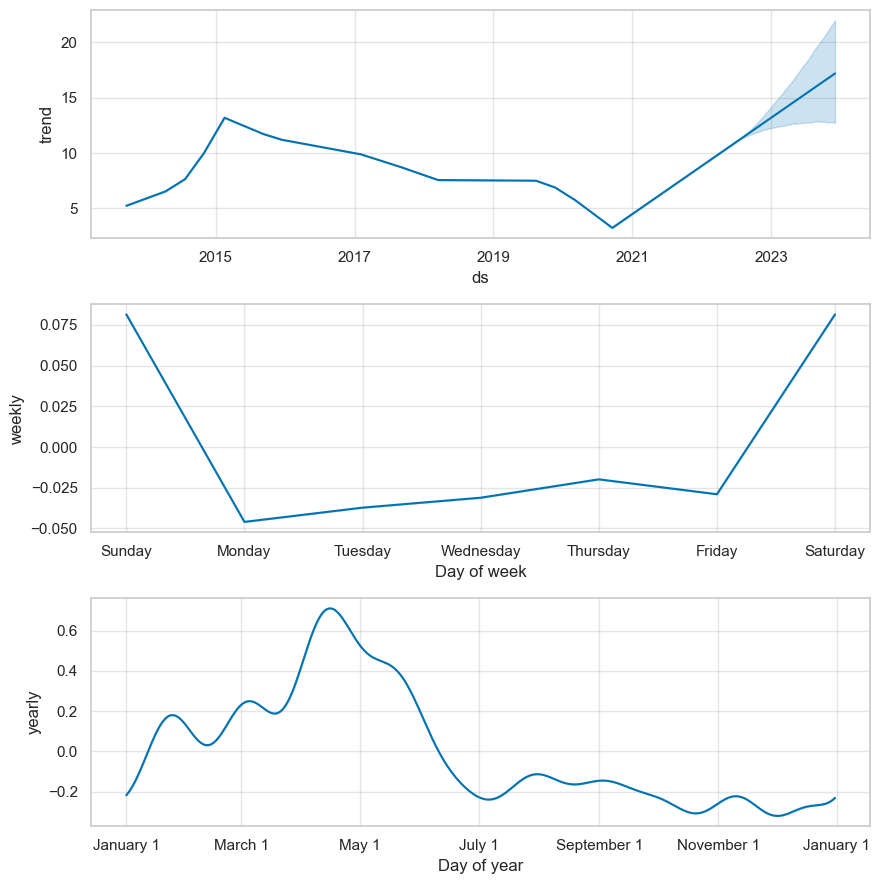

In [9]:
# Смотрим тренд, годовые и сезонные признаки
fig = model_baseline.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [10]:
# Создание df с прогнозом
df_test_forecast = model_baseline.predict(df_test)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
537,2024-07-24,19.806299,11.947275,27.797271
538,2024-07-25,19.835073,11.821548,28.168423
539,2024-07-26,19.842632,11.730202,27.811388
540,2024-07-29,19.870510,11.846081,28.091482
541,2024-07-30,19.892380,12.011754,28.107136


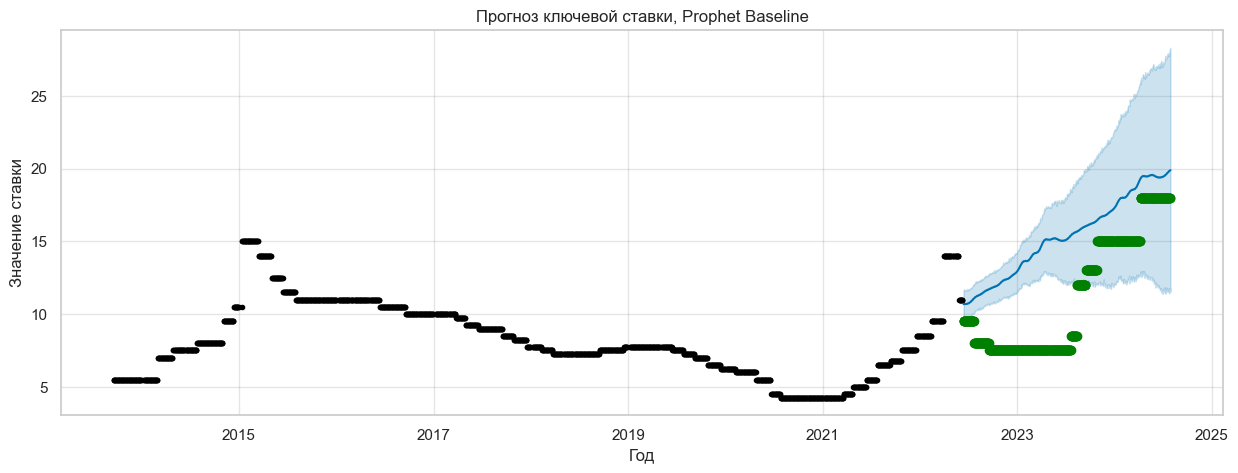

In [11]:
# Смотрим совпадение фактического курса с предсказанным курсом prophet baseline обученным на train
fig, ax = plt.subplots(figsize= (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
predict = model_baseline.predict(df_test)
fig = model_baseline.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet Baseline')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

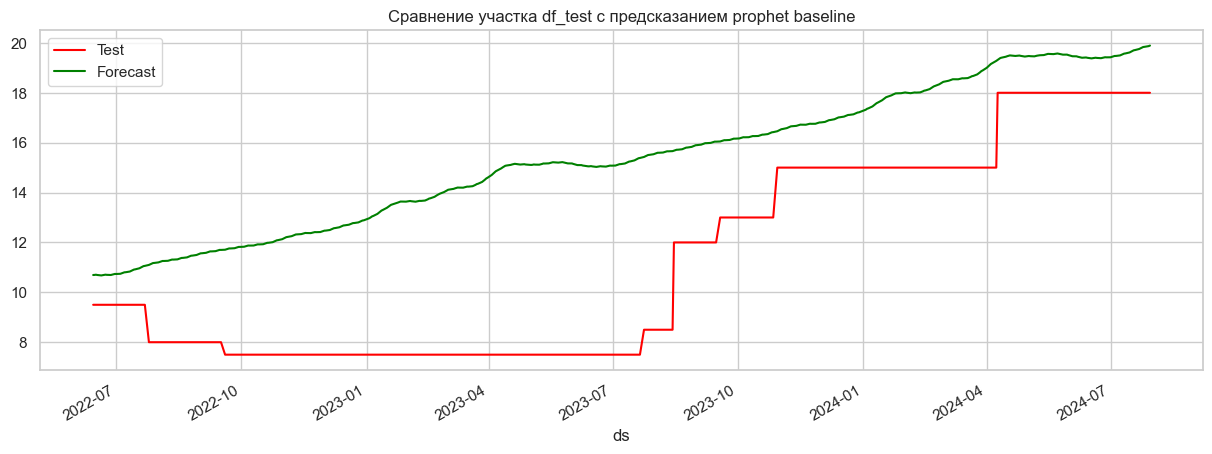

In [12]:
# Сравнение участка df_test с предсказанием prophet baseline
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet baseline')
plt.show()

In [13]:
# Просмотр метрик модели обученной на train
metrics = get_metrics(y_test=df_test['y'], y_pred=df_test_forecast['yhat'], name='Prophet_baseline')
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,4.104729,0.467489,21.539481,4.641065


Из приведенного выше графика мы видим, что существует разрыв в прогнозах и фактических данных. Поэтому нам нужно оптимизировать модель, добавив другие параметры, напрмиер, такие как праздники

# Prophet with holidays

In [14]:
# Создаем df праздников в РФ начиная с 2013 по сегодня
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]).items()):
    new_row = pd.DataFrame({'ds': date, 'holiday': "RU-Holidays"}, index=[0])
    holiday = pd.concat([holiday, new_row], ignore_index=True)  

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [15]:
# Тренировка модели с праздниками
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(df_train)

00:33:55 - cmdstanpy - INFO - Chain [1] start processing
00:33:56 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
# Создание df с прогнозом
future = model_with_holidays.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2705,2023-11-30,16.747159,12.507830,21.116754
2706,2023-12-01,16.748705,12.498491,21.298758
2707,2023-12-02,16.869456,12.744600,21.130882
2708,2023-12-03,16.882118,12.654457,21.154369
2709,2023-12-04,16.769928,12.542585,21.331141


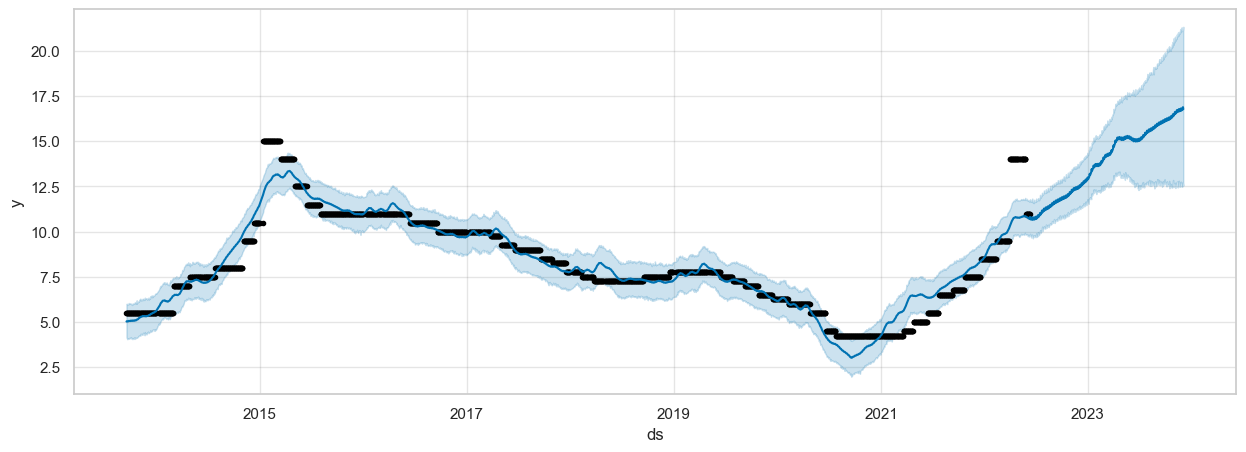

In [17]:
# Смотрим график прогноза с праздниками
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

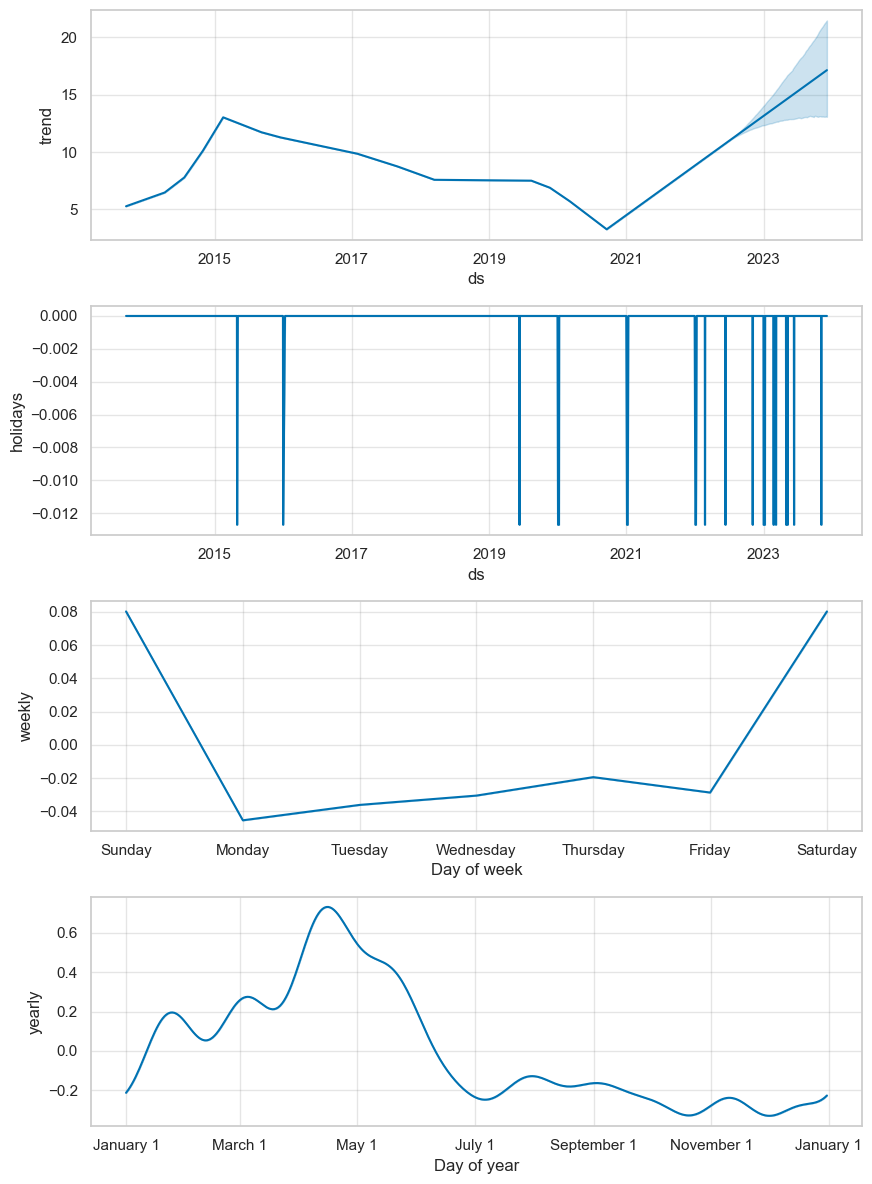

In [18]:
# Смотрим тренд, годовые и сезонные признаки обученной модели с праздниками
fig = model_with_holidays.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [19]:
# Создание df с прогнозом
df_test_forecast_holiday = model_with_holidays.predict(df_test)
df_test_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
537,2024-07-24,19.724672,12.829177,27.456922
538,2024-07-25,19.752942,12.752894,27.600037
539,2024-07-26,19.760058,12.611135,27.344888
540,2024-07-29,19.787315,12.648247,27.637003
541,2024-07-30,19.809429,12.578378,27.726617


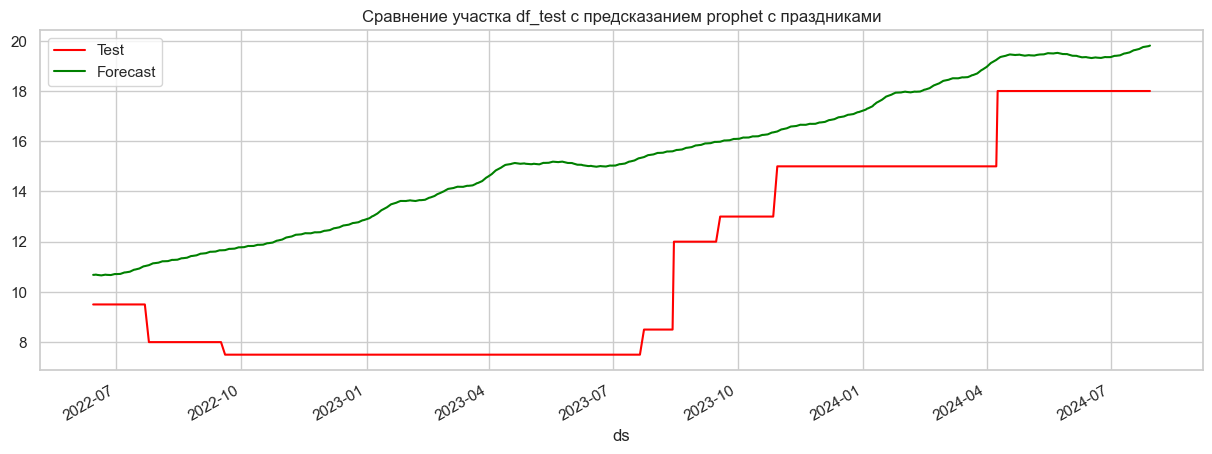

In [20]:
# Сравнение участка df_test с предсказанием prophet_with_holidays
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet с праздниками')
plt.show()

In [21]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_holiday['yhat'], name='Prophet_with_holidays')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,4.104729,0.467489,21.539481,4.641065
0,Prophet_with_holidays,4.060951,0.463454,21.220520,4.606574


Из метрик и графиков видим, что модель с праздниками показывает результаты немного изменились.

# Тюнинг тест модели

In [22]:
# Создание сетки параметров и подсчёт количества вариаций обучения
params_grid = {
    'changepoint_prior_scale': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.3, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1, 10], 
    'holidays_prior_scale': [0.01, 0.1, 1, 10],
    'seasonality_mode': ('multiplicative','additive')
}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt + 1

print('Количество моделей для обучения по сетке:', cnt)

Количество моделей для обучения по сетке: 672


In [23]:
"""Обучение тестовой модели по сетке параметров на df_train"""
# Создаем пустой DataFrame для сохранения метрик и параметров
model_grid_metrics = pd.DataFrame()
model_grid_parameters = pd.DataFrame(columns = ['Parameters'])

# Проходимся по сетке гиперпараметров
for p in tqdm(grid):
    
    # Обучаем Prophet по сетке гиперпараметров
    model_grid = Prophet(
        changepoint_prior_scale = p['changepoint_prior_scale'],
        seasonality_prior_scale = p['seasonality_prior_scale'],
        holidays_prior_scale = p['holidays_prior_scale'],
        seasonality_mode = p['seasonality_mode'],
        #changepoint_range = p['changepoint_range'],
        #holidays=holiday,
    )

    # Добавляем праздники в модель
    #model_grid.add_country_holidays(country_name='RU')

    # Обучаем модель
    model_grid.fit(df_train)

    # Создаем фрейм данных для предсказаний
    model_grid_future = model_grid.make_future_dataframe(periods=pred_days, freq='D', include_history=False)

    # Делаем предсказания
    model_grid_forecast = model_grid.predict(model_grid_future)

    # Вычисляем метрики и добавляем новую строку в df
    model_grid_metrics = pd.concat([model_grid_metrics, get_metrics(y_test=df_test['y'], y_pred=model_grid_forecast['yhat'], name='Prophet_with_grid ')])
    model_grid_parameters = pd.concat([model_grid_parameters, pd.DataFrame({'Parameters': [p]})], ignore_index=True)


  0%|          | 0/672 [00:00<?, ?it/s]

00:34:02 - cmdstanpy - INFO - Chain [1] start processing
00:34:03 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/672 [00:01<12:01,  1.08s/it]00:34:04 - cmdstanpy - INFO - Chain [1] start processing
00:34:04 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 2/672 [00:02<12:45,  1.14s/it]00:34:05 - cmdstanpy - INFO - Chain [1] start processing
00:34:05 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 3/672 [00:03<12:14,  1.10s/it]00:34:06 - cmdstanpy - INFO - Chain [1] start processing
00:34:06 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 4/672 [00:04<13:22,  1.20s/it]00:34:07 - cmdstanpy - INFO - Chain [1] start processing
00:34:08 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 5/672 [00:05<13:02,  1.17s/it]00:34:08 - cmdstanpy - INFO - Chain [1] start processing
00:34:09 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 6/672 [00:06<12:18,  1.11s/it]00:34:09 - cmdstanpy - INFO - Chain [1] 

In [24]:
# Сброс индексов для будущего объединения с df параметров сетки
model_grid_metrics = model_grid_metrics.reset_index(drop=True)

In [25]:
# Объединение DataFrame по столбцам
metrics_parameters_with_grid = pd.concat([model_grid_metrics, model_grid_parameters], axis=1)
metrics_parameters_with_grid

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,4.908880,0.360059,41.798672,6.465189,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
1,Prophet_with_grid,5.085905,0.378178,43.885629,6.624623,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
2,Prophet_with_grid,5.187289,0.388048,45.046686,6.711683,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
3,Prophet_with_grid,5.137726,0.383226,44.480045,6.669336,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
4,Prophet_with_grid,4.737933,0.342799,40.570481,6.369496,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
...,...,...,...,...,...,...
667,Prophet_with_grid,12.547565,1.236213,377.756869,19.435968,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
668,Prophet_with_grid,3.497231,0.418460,17.504376,4.183823,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
669,Prophet_with_grid,3.487521,0.417134,17.380487,4.168991,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
670,Prophet_with_grid,3.467964,0.414912,17.217685,4.149420,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."


In [26]:
# Сортировка по метрике
metrics_parameters_with_grid = metrics_parameters_with_grid.sort_values(by=['MAE'])
metrics_parameters_with_grid = metrics_parameters_with_grid.reset_index(drop=True)
metrics_parameters_with_grid.head()

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,2.805856,0.28250,9.834032,3.135926,"{'changepoint_prior_scale': 0.01, 'holidays_pr..."
1,Prophet_with_grid,2.805856,0.28250,9.834032,3.135926,"{'changepoint_prior_scale': 0.01, 'holidays_pr..."
2,Prophet_with_grid,2.805856,0.28250,9.834032,3.135926,"{'changepoint_prior_scale': 0.01, 'holidays_pr..."
3,Prophet_with_grid,2.805856,0.28250,9.834032,3.135926,"{'changepoint_prior_scale': 0.01, 'holidays_pr..."
4,Prophet_with_grid,2.808433,0.28468,9.855978,3.139423,"{'changepoint_prior_scale': 0.008, 'holidays_p..."


## Лучшие параметры после обучения по сетке

In [27]:
# Сохранение в переменную лучших параметров после обучения по сетке
best_params = metrics_parameters_with_grid['Parameters'][0]

# Просмотр лучших параметров
best_params

{'changepoint_prior_scale': 0.01,
 'holidays_prior_scale': 1,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 0.01}

In [28]:
# Обучение модели на лучших параметрах
final_test_model = Prophet(**best_params)
final_test_model.fit(df_train)

00:54:36 - cmdstanpy - INFO - Chain [1] start processing
00:54:36 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
# Создание df с прогнозом
future = final_test_model.make_future_dataframe(periods=pred_days, freq='D')
forecast = final_test_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2705,2023-11-30,13.558183,11.766848,15.503926
2706,2023-12-01,13.561243,11.815195,15.448637
2707,2023-12-02,13.586820,11.755905,15.591298
2708,2023-12-03,13.597352,11.963471,15.432898
2709,2023-12-04,13.562082,11.754361,15.404714


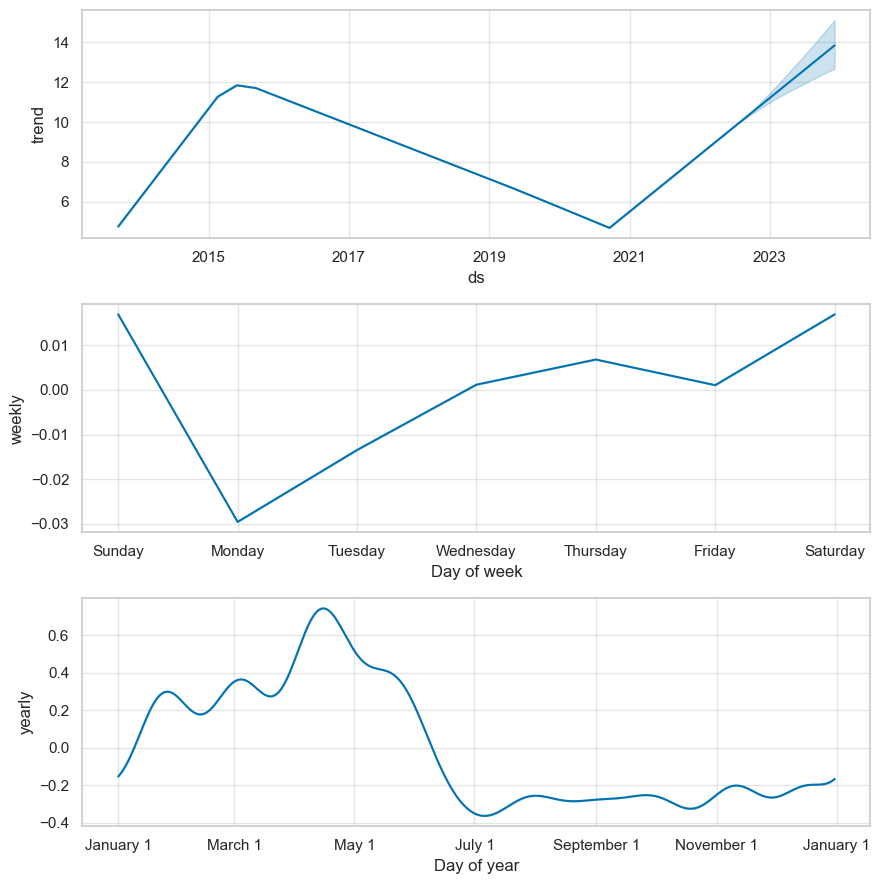

In [30]:
# Смотрим тренд, годовые и сезонные признаки
fig = final_test_model.plot_components(forecast)

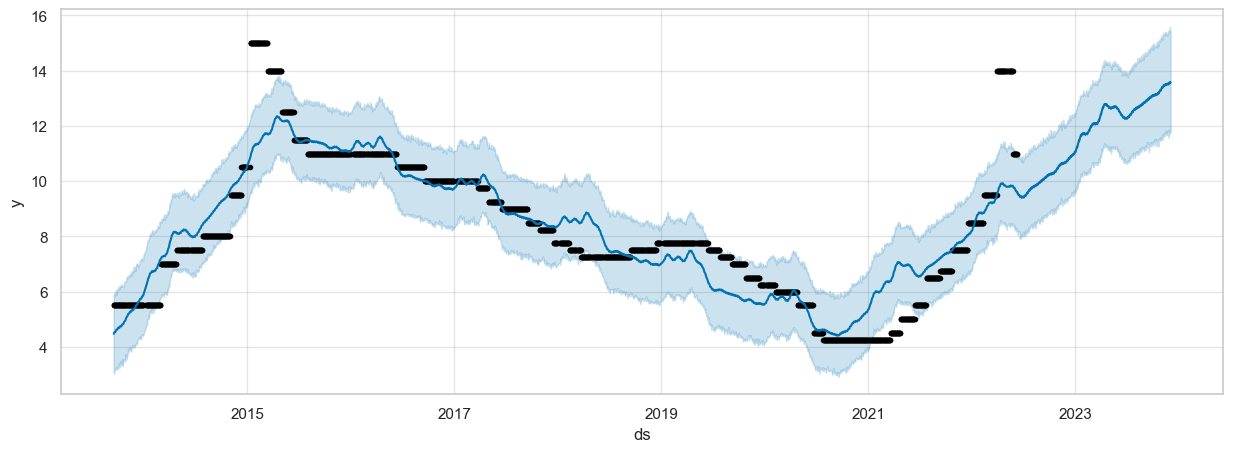

In [31]:
# Смотрим график прогноза после обучния на лучших параметрах
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast,ax=ax)
plt.show()

## Сравнение фактов и прогнозов

In [32]:
# Создание df с прогнозом
df_test_forecast_final = final_test_model.predict(df_test)
df_test_forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
537,2024-07-24,15.395883,12.844234,17.768937
538,2024-07-25,15.413916,12.884246,17.879062
539,2024-07-26,15.419988,12.850498,17.920449
540,2024-07-29,15.421024,12.769860,17.848742
541,2024-07-30,15.446428,12.994575,17.806165


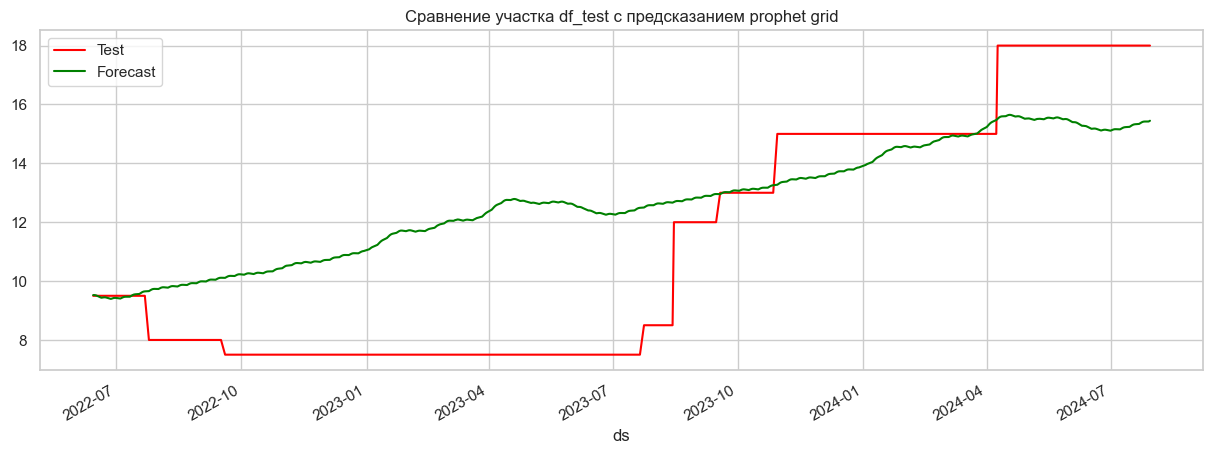

In [33]:
# Сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet grid')
plt.show()

In [34]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_final['yhat'], name='Prophet_with_grid')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,4.104729,0.467489,21.539481,4.641065
0,Prophet_with_holidays,4.060951,0.463454,21.220520,4.606574
0,Prophet_with_grid,2.467795,0.283629,8.976110,2.996016


In [35]:
# Сохранение модели в JSON файл
with open('../models/final_test_model.json', 'w') as fout:
    fout.write(model_to_json(final_test_model))

# Baseline NeuralProphet on df_train для проверки модели

In [36]:
# Обучение модели на df
NeuralProphet_bl = NeuralProphet()
NeuralProphet_bl.set_plotting_backend("plotly-static")
metricsnp = NeuralProphet_bl.fit(df_train)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.14% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (34) is too small than the required number                     for the learning rate finder (233). The results might not be optimal.


Finding best initial lr:   0%|          | 0/233 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [37]:
# Создание df с прогнозом
future_np_bl = NeuralProphet_bl.make_future_dataframe(df_train, periods = pred_days, n_historic_predictions = True)
forecast_np_bl = NeuralProphet_bl.predict(df_test)
forecast_np_bl.tail()

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.14% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.417% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.417% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B


Predicting: 34it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly
537,2024-07-24,18.0,12.242473,5.121624,-0.438849,7.559698
538,2024-07-25,18.0,12.243156,5.126833,-0.432001,7.548324
539,2024-07-26,18.0,12.250694,5.132042,-0.425152,7.543804
540,2024-07-29,18.0,12.259769,5.147668,-0.405146,7.517247
541,2024-07-30,18.0,12.291167,5.152875,-0.398815,7.537107


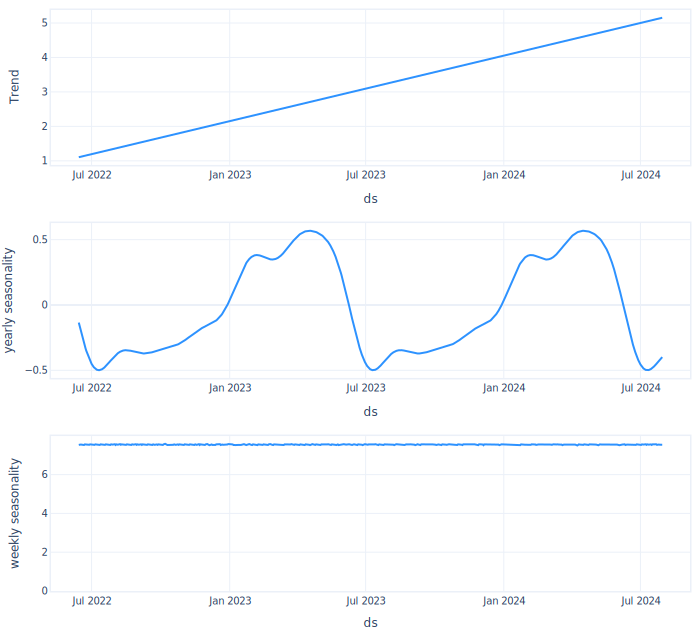

In [38]:
# Смотрим тренд, годовые и сезонные признаки
NeuralProphet_bl.plot_components(forecast_np_bl)

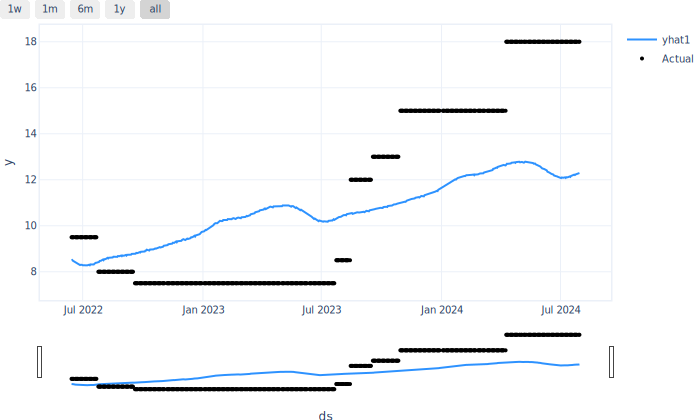

In [39]:
# Смотрим график прогноза после обучения
fig = NeuralProphet_bl.plot(forecast_np_bl, ax=ax)

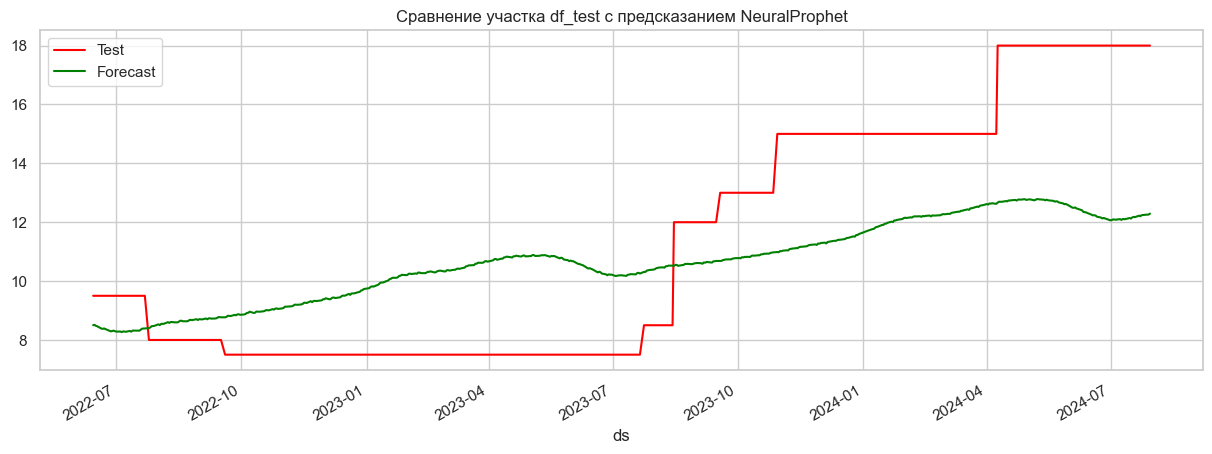

In [40]:
# Сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
forecast_np_bl.plot(kind='line',x='ds',y='yhat1', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием NeuralProphet')
plt.show()

In [41]:
# Сравниваем метрики после добавления NeuralProphet
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=forecast_np_bl['yhat1'], name='NeuralProphet')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,4.104729,0.467489,21.539481,4.641065
0,Prophet_with_holidays,4.060951,0.463454,21.220520,4.606574
0,Prophet_with_grid,2.467795,0.283629,8.976110,2.996016
0,NeuralProphet,2.785852,0.252927,9.764398,3.124804


# Обучение и прогнозирование курса ставки рефинансирования ЦБ РФ на полных данных

# Prophet baseline on df

In [42]:
# Обучение модели на df
prophet_bl = Prophet()
prophet_bl.fit(df)

00:55:17 - cmdstanpy - INFO - Chain [1] start processing
00:55:18 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
# Создание df с прогнозом
future_bl = prophet_bl.make_future_dataframe(periods=pred_days_forecast, freq='D')
forecast_bl = prophet_bl.predict(future_bl)
forecast_bl[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2885,2025-01-22,17.857847,15.892694,19.776859
2886,2025-01-23,17.878230,15.825636,19.822717
2887,2025-01-24,17.882677,16.102045,19.967862
2888,2025-01-25,18.696742,16.771253,20.631678
2889,2025-01-26,18.704067,16.583323,20.569386


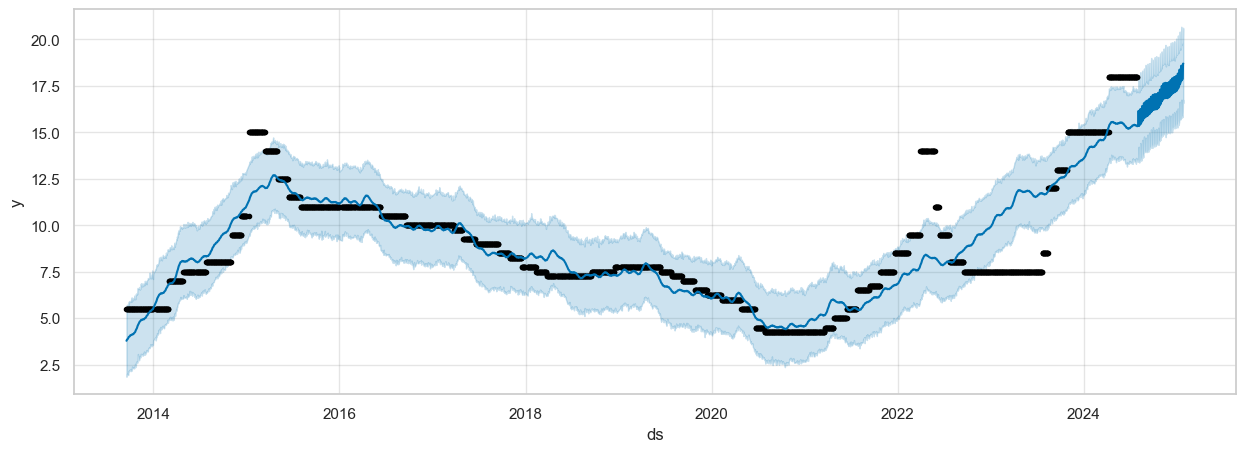

In [44]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = prophet_bl.plot(forecast_bl,ax=ax)
plt.show()

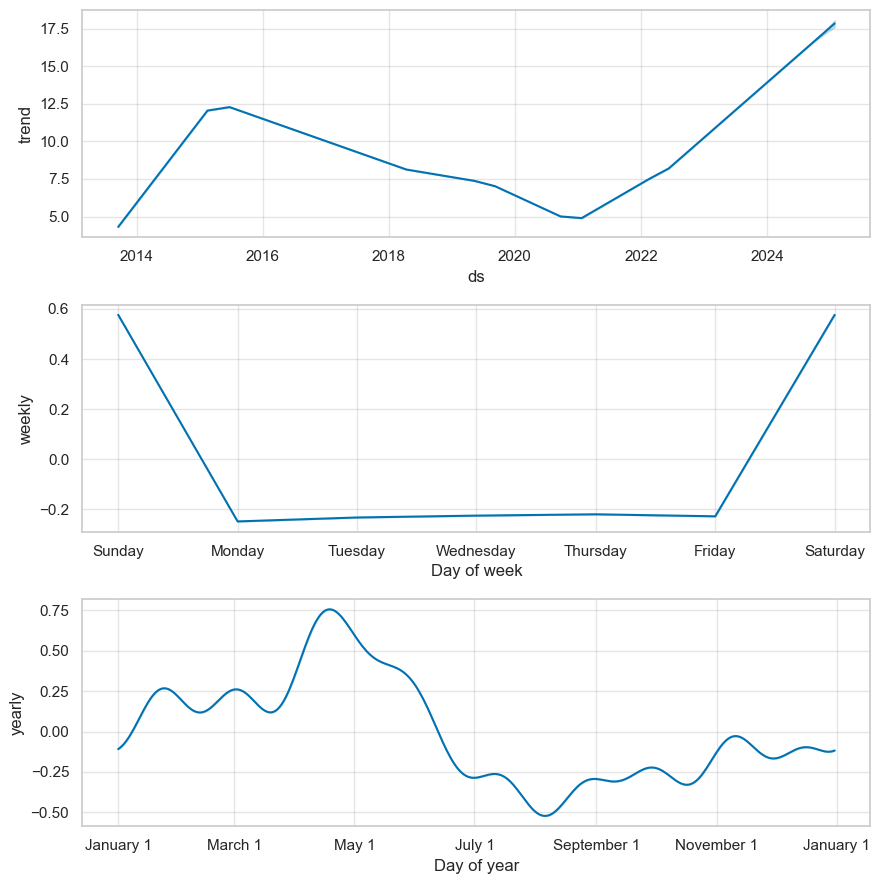

In [45]:
# Смотрим тренд, годовые и сезонные признаки
fig = prophet_bl.plot_components(forecast_bl)
plt.show()

# Prophet best params on df

In [46]:
# Обучение модели на df
final_test_model = Prophet()
final_test_model.fit(df)

00:55:22 - cmdstanpy - INFO - Chain [1] start processing
00:55:23 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
# Создание df с прогнозом
future_ftm = final_test_model.make_future_dataframe(periods=pred_days_forecast, freq='D')
forecast_ftm = final_test_model.predict(future_ftm)
forecast_ftm[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2885,2025-01-22,17.857847,15.875199,19.772217
2886,2025-01-23,17.878230,16.112051,19.804652
2887,2025-01-24,17.882677,15.801525,19.851754
2888,2025-01-25,18.696742,16.786500,20.702954
2889,2025-01-26,18.704067,16.745878,20.537367


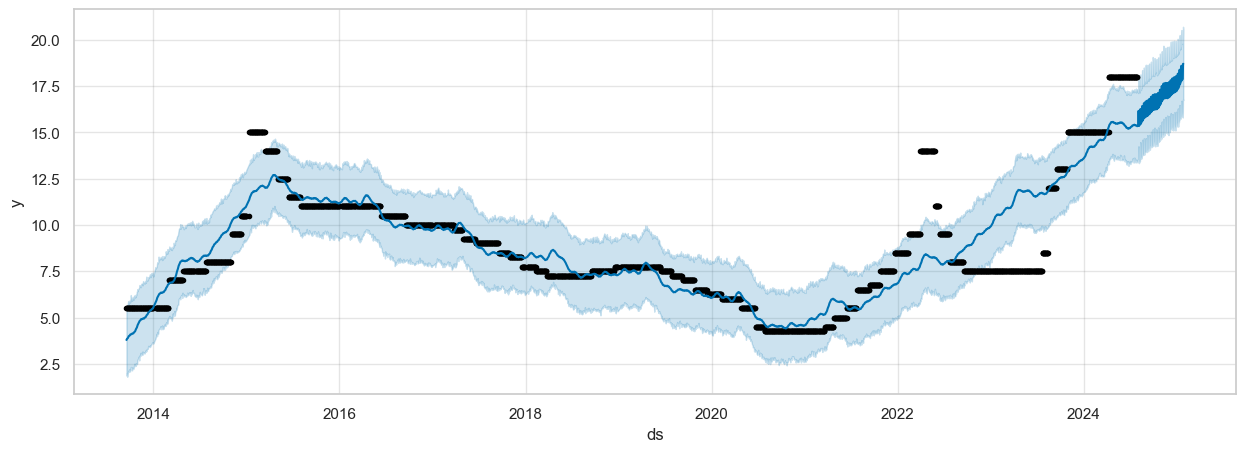

In [48]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast_ftm,ax=ax)
plt.show()

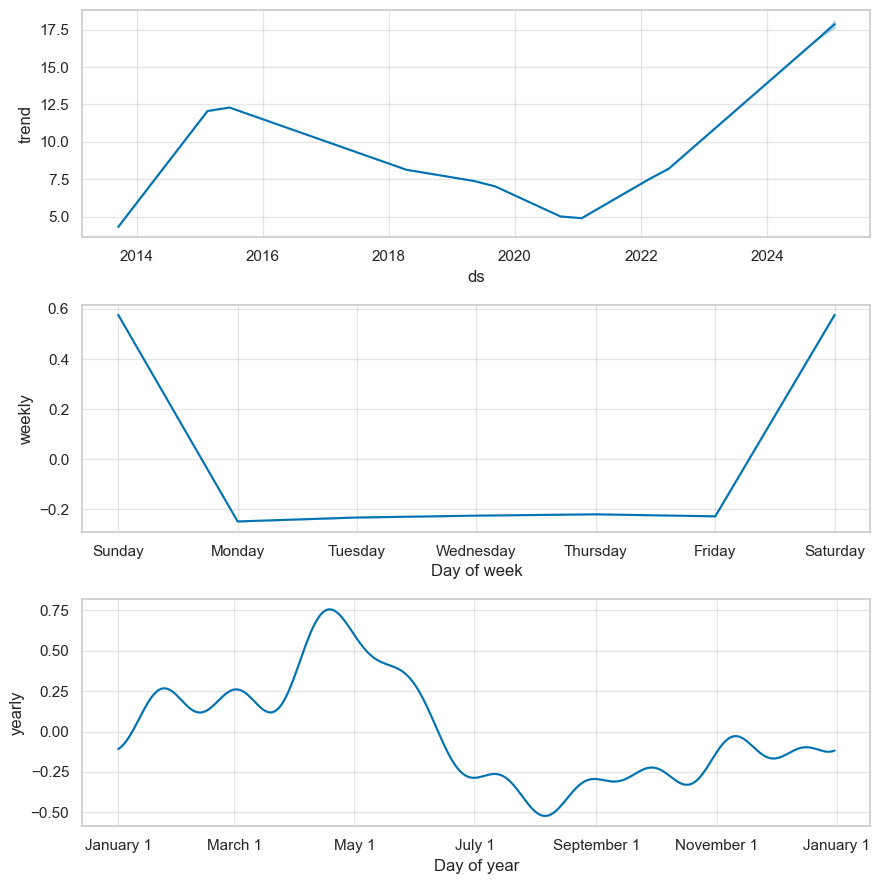

In [49]:
# Смотрим тренд, годовые и сезонные признаки
fig = prophet_bl.plot_components(forecast_ftm)
plt.show()

# NeuralProphet on df

In [50]:
# Обучение модели на df
NeuralProphet_df = NeuralProphet()
NeuralProphet_df.set_plotting_backend("plotly-static")
metricsnp = NeuralProphet_df.fit(df,)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.196% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 80
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (43) is too small than the required number                     for the learning rate finder (236). The results might not be optimal.


Finding best initial lr:   0%|          | 0/236 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [51]:
# Создание df с прогнозом
future_np = NeuralProphet_df.make_future_dataframe(df, periods = pred_days_forecast-104, n_historic_predictions = True)
forecast_np = NeuralProphet_df.predict(future_np)
forecast_np.tail()

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.196% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.272% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.272% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.data.processing._handle_missing_data) - Dropped 76 rows at the end with NaNs in 'y' column.


Predicting: 43it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly
2781,2024-11-07,NaN,16.616158,14.760399,-0.079008,1.934766
2782,2024-11-08,NaN,16.618645,14.769836,-0.073928,1.922737
2783,2024-11-11,NaN,16.641640,14.798144,-0.063040,1.906534
2784,2024-11-12,NaN,16.669132,14.807584,-0.060878,1.922427
2785,2024-11-13,NaN,16.677622,14.817019,-0.059445,1.920048


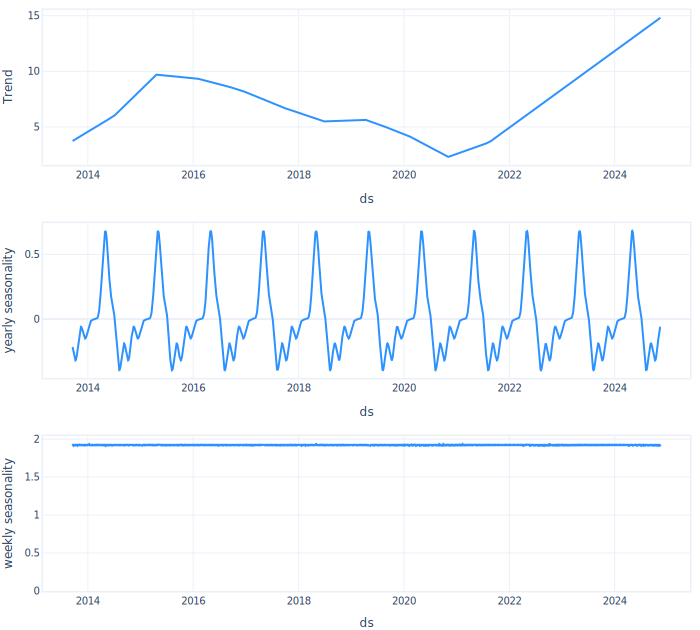

In [52]:
# Смотрим тренд, годовые и сезонные признаки
NeuralProphet_df.plot_components(forecast_np)

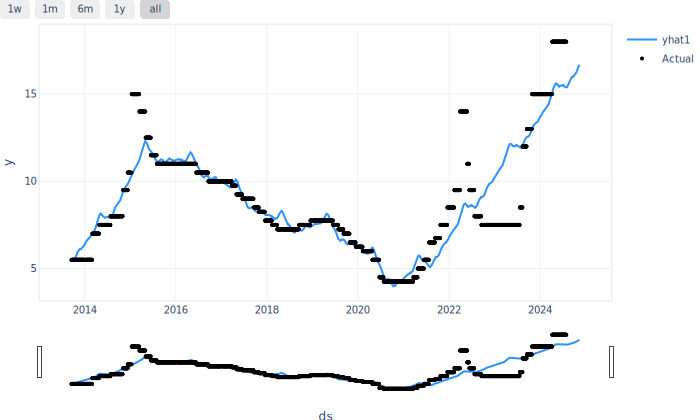

In [53]:
# Смотрим график прогноза
NeuralProphet_df.plot(forecast_np)

# Сравнение прогнозов обученных моделей

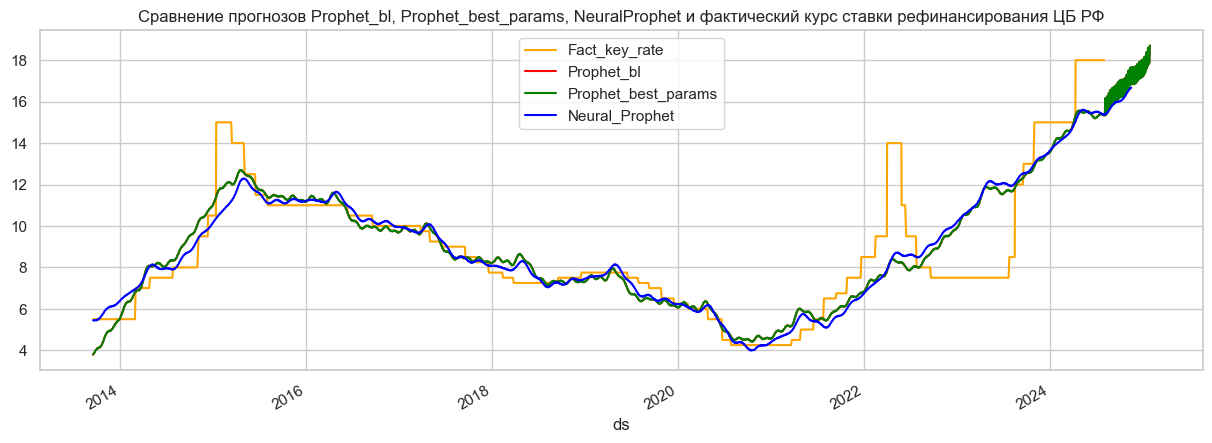

In [54]:
# Сравнение прогнозов Prophet_bl, Prophet_best_params, NeuralProphet и фактический курс ставки рефинансирования ЦБ РФ
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df.plot(kind='line',x='ds', y='y', color='orange', label='Fact_key_rate', ax=ax)
forecast_bl.plot(kind='line', x='ds', y='yhat', color='red', label='Prophet_bl', ax=ax)
forecast_ftm.plot(kind='line', x='ds', y='yhat', color='green', label='Prophet_best_params', ax=ax)
forecast_np.plot(kind='line', x='ds', y='yhat1', color='blue', label='Neural_Prophet', ax=ax)
plt.title('Сравнение прогнозов Prophet_bl, Prophet_best_params, NeuralProphet и фактический курс ставки рефинансирования ЦБ РФ')
plt.show()

Исходя из графиков, видно что Prophet с лучшими параметрами, лучше предсказал курс ключевой ставки ЦБ РФ.